In [110]:
import numpy as np
import pandas as pd
import itertools
import scipy.stats as stats
from scipy.stats import pearsonr


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot



# colors
import matplotlib.colors as mcolors
import colorsys

def lighten_color(color, factor=1.7):
    """Lightens color."""
    rgb = mcolors.to_rgb(color)  
    h, l, s = colorsys.rgb_to_hls(*rgb) 
    l = min(1.0, l * factor) 
    new_rgb = colorsys.hls_to_rgb(h, l, s)  
    return new_rgb


c_p1 = 'steelblue'
c_p2 = 'orange'
c_h1 = lighten_color(c_p1)
c_h2 = lighten_color(c_p2)

fs = 20

In [ ]:
results_path = '../results/'
data_path = '../data/'

In [111]:
weights = pd.read_csv(results_path + 'weights_log_additive.csv',header=0,index_col=0)
sig_df = pd.read_csv(results_path + 'sig_log_additive.csv',header=0,index_col=0)
design_matrix = pd.read_csv(results_path + 'design_matrix_log_additive.csv',header=0,index_col=0)
design_matrix = design_matrix.values
dm = design_matrix[::6,:] 

actual_values = pd.read_csv(data_path + 'male_LiverBAT_warmcold_X.txt',delimiter='\t',header=None).T.values


# actual values
cell_size = 1200
actual_values_norm = actual_values/actual_values.sum(axis=0)*cell_size
actual_values_norm.shape

# predicted counts
pred_counts = weights@dm.T + np.log(cell_size)
pred_counts = np.exp(pred_counts)


p1_index = np.array( [True]*24 + [False]*72 ) 
p2_index = np.array( [False]*24 + [True]*24 + [False]*48 )
h1_index = np.array( [False]*48 + [True]*24 + [False]*24 )
h2_index = np.array( [False]*72 + [True]*24 )

tissue_index = [[True]*12+[False]*12]*4
tissue_index = np.array( [item for sublist in tissue_index for item in sublist] )

temp_index = [[True]*6+[False]*6]*8
temp_index = np.array( [item for sublist in temp_index for item in sublist] )


# gene names
gene_names_raw1 = pd.read_csv(data_path + "gProfiler_gene_names_1.csv")
gene_names_raw = pd.read_csv(data_path + "gProfiler_gene_names.csv")
# concatenate
gene_names_df = pd.concat((gene_names_raw1,gene_names_raw)).sort_values(by='name',ascending=True)
gene_names = np.sort(gene_names_df.name.values)
gene_names_df = gene_names_df.set_index('initial_alias')

In [112]:
# choose some genes 
overall_cis = (sig_df['BH_FDR_beta_cis'].values<=0.05)&(sig_df['BH_FDR_beta_trans'].values>0.05)
overall_trans = (sig_df['BH_FDR_beta_cis'].values>0.05)&(sig_df['BH_FDR_beta_trans'].values<=0.05)

tissue_cis = (sig_df['BH_FDR_beta_cis.BAT'].values<=0.05)&(sig_df['BH_FDR_beta_trans.BAT'].values>0.05)
tissue_trans = (sig_df['BH_FDR_beta_cis.BAT'].values>0.05)&(sig_df['BH_FDR_beta_trans.BAT'].values<=0.05)

temp_cis = (sig_df['BH_FDR_beta_cis.Cold'].values<=0.05)&(sig_df['BH_FDR_beta_trans.Cold'].values>0.05)
temp_trans = (sig_df['BH_FDR_beta_cis.Cold'].values>0.05)&(sig_df['BH_FDR_beta_trans.Cold'].values<=0.05)

sum(overall_cis),sum(overall_trans),sum(tissue_cis),sum(tissue_trans),sum(temp_cis),sum(temp_trans)


(625, 348, 485, 315, 266, 209)

In [113]:
gene_names_to_plot = ['Galnt1',
                 'Coasy',
                 'Gmnn',
                 'Samd8',
                 'Map3k14', 
                 'Mus81',
                 ]

gene_ids_to_plot = [gene_names_df[gene_names_df.name==g].index[0] for g in gene_names_to_plot]

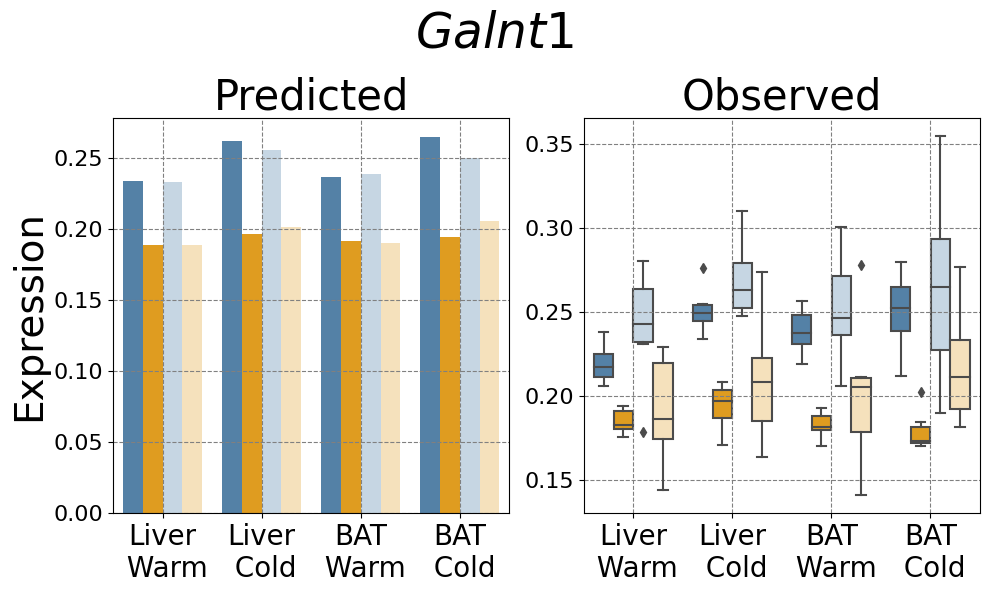

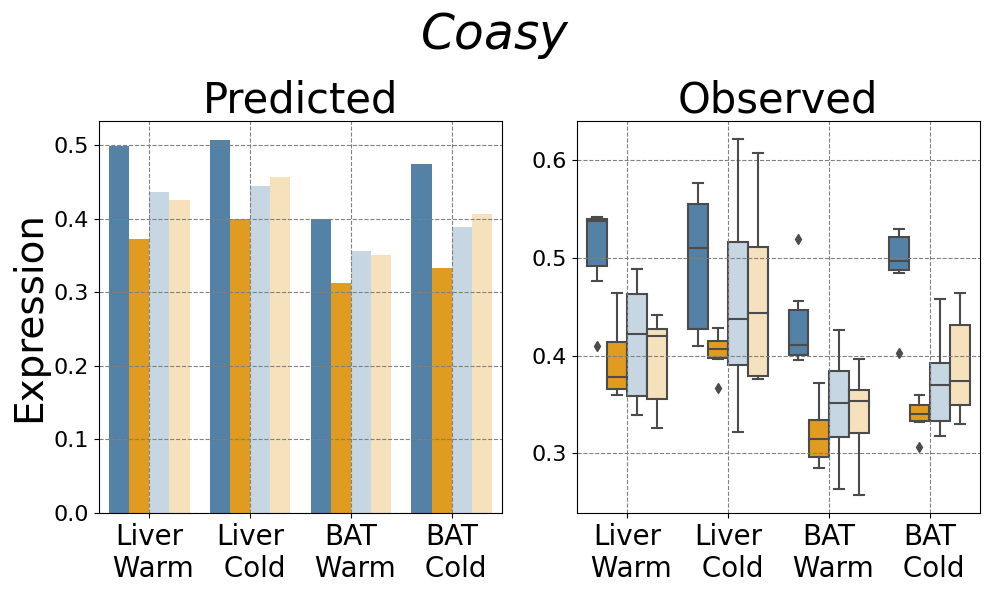

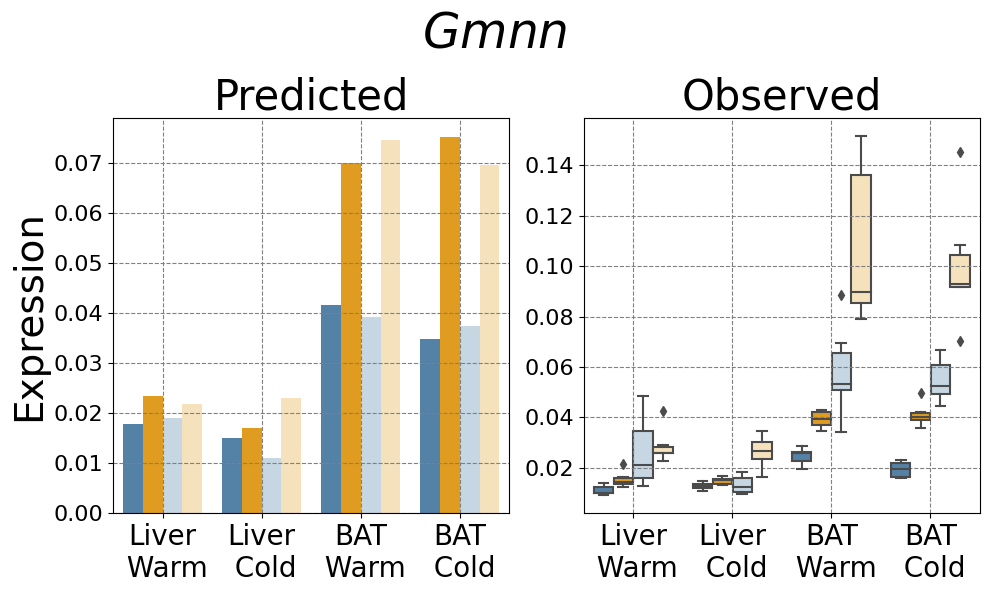

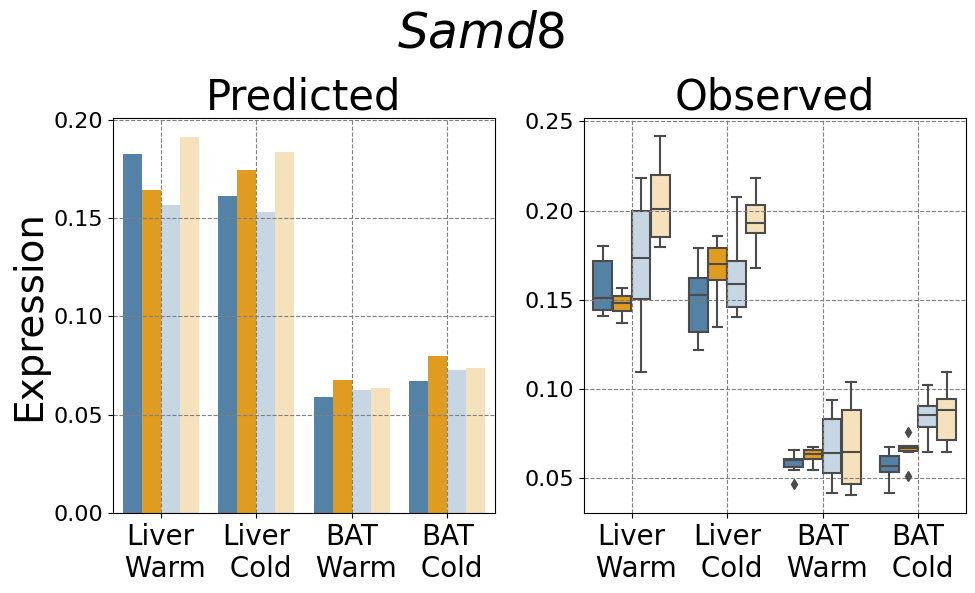

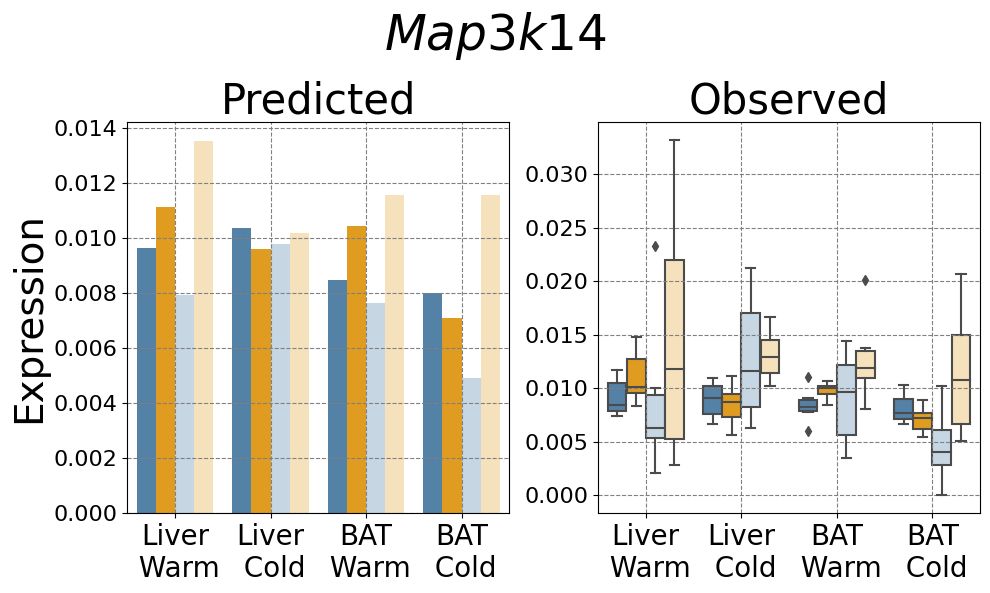

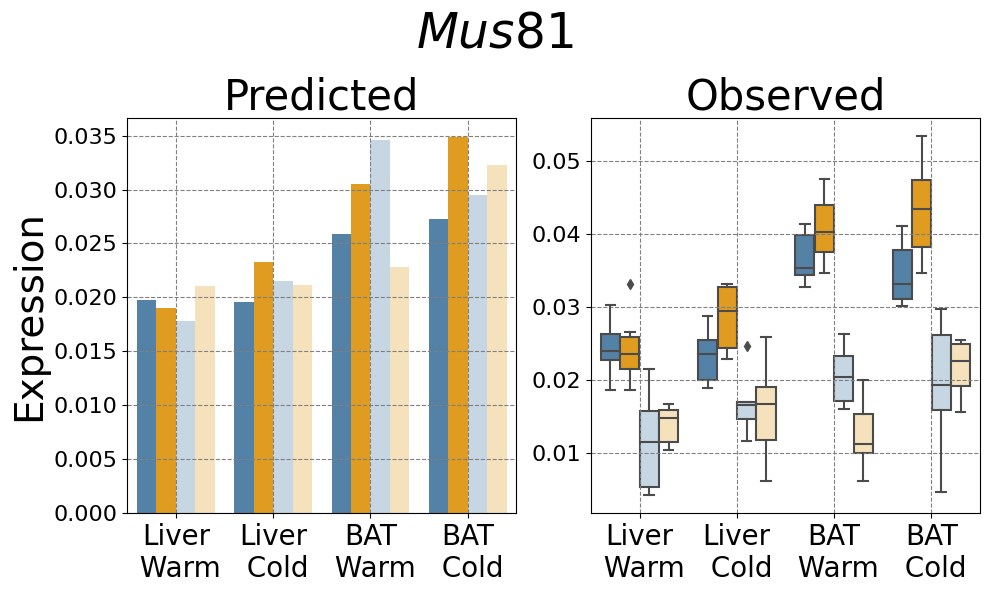

In [114]:
fs_title = 30
fs_suptitle = 35
fs_label = 28
fs_xtick = 20
fs_ytick = 16

genes_ = gene_ids_to_plot
g_names = [] 

for g,gene in enumerate(genes_):
    g_index = np.where(sig_df.index==gene)[0][0]
    g_indices.append(g_index)
    name_ = gene_names_df.loc[gene]['name']
    g_names.append(   name_  )
    
    
    values = pred_counts.loc[gene].values
    gene_counts_ = actual_values[g_index,:]
    gene_counts_norm_ = actual_values_norm[g_index]

    categories = ["X_P1"]*4+["X_P2"]*4+["X_H1"]*4+["X_H2"]*4

    supergroups = ["Liver\n Warm", "Liver\n Cold", "BAT\n Warm", "BAT\n Cold"]*4

    df = pd.DataFrame({
        "Expression": values,
        "Sample": categories,
        "Tissue-Env": supergroups
    })

    supergroup_colors = {
        "X_P1": c_p1,
        "X_P2": c_p2,
        "X_H1": c_h1,
        "X_H2": c_h2,
    }

    df["Color"] = df["Sample"].map(supergroup_colors)

    fig,axes = plt.subplots(1,2,figsize=(10, 6))

    sns.barplot(
        data=df,
        x="Tissue-Env",
        y="Expression",
        hue="Sample",
        palette=df["Color"].unique(),
        ax = axes[0]
    )



    df_gene_plot_ = {}

    condition_array = np.array(['']*96)
    allele_array =  np.array(['']*96)

    df_gene_plot_["Condition"]=condition_array
    df_gene_plot_["Allele"]=allele_array
    df_gene_plot_["Counts"]=gene_counts_
    df_gene_plot_["Normalized_Counts"]=gene_counts_norm_

    df_gene_plot_ = pd.DataFrame(df_gene_plot_)

    df_gene_plot_.loc[p1_index,"Allele"] = 'P1'
    df_gene_plot_.loc[p2_index,"Allele"] = 'P2'
    df_gene_plot_.loc[h1_index,"Allele"] = 'H1'
    df_gene_plot_.loc[h2_index,"Allele"] = 'H2'

    df_gene_plot_.loc[(tissue_index&temp_index),"Condition"]='Liver\n Warm'
    df_gene_plot_.loc[tissue_index&~temp_index,"Condition"]='Liver\n Cold'
    df_gene_plot_.loc[~tissue_index&temp_index,"Condition"]='BAT\n Warm'
    df_gene_plot_.loc[~tissue_index&~temp_index,"Condition"]='BAT\n Cold'

    sns.boxplot(data=df_gene_plot_,
            x='Condition',
            y='Normalized_Counts',
            hue='Allele',
            palette=df["Color"].unique(),
            ax=axes[1])
    

    # axes[0].set_title('Predicted',fontsize=fs_title)
    # axes[1].set_title('Observed',fontsize=fs_title)

    axes[0].set_xlabel("",fontsize=fs_label)
    axes[0].set_ylabel("Expression",fontsize=fs_label)

    axes[1].set_xlabel("",fontsize=fs_label)
    axes[1].set_ylabel("",fontsize=fs_label)


    axes[0].grid(linestyle='--',color='gray')
    axes[1].grid(linestyle='--',color='gray')
    axes[0].legend().remove()
    axes[1].legend().remove()

    axes[0].tick_params(axis="x", labelsize=fs_xtick)
    axes[1].tick_params(axis="x", labelsize=fs_xtick)

    axes[0].tick_params(axis="y", labelsize=fs_ytick)
    axes[1].tick_params(axis="y", labelsize=fs_ytick)


    axes[0].set_title("Predicted",fontsize=fs_title)
    axes[1].set_title("Observed",fontsize=fs_title)

    plt.suptitle(f'${name_}$',fontsize=fs_suptitle)

    plt.tight_layout()
    plt.show();

/tmp/ipykernel_439565/2231283979.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  heatmap_weights = np.array(coef_df,dtype=np.float)


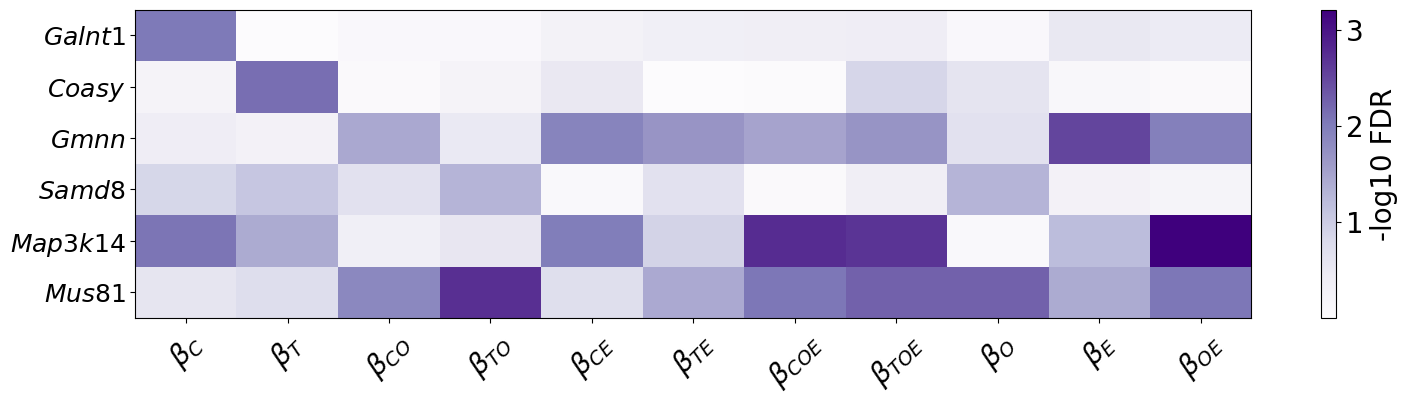

In [133]:
# pvals or weights
full_model_coefficients = [r"$\beta$", r"$\beta_{C}$", r"$\beta_{T}$", 
              r"$\beta_{CO}$", r"$\beta_{TO}$", 
              r"$\beta_{CE}$", r"$\beta_{TE}$", 
              r"$\beta_{COE}$", r"$\beta_{TOE}$",
              r"$\beta_{O}$", r"$\beta_{E}$", r"$\beta_{OE}$",]

col_order1 = ['beta_cis', 'beta_trans', 'beta_cis*BAT', 'beta_trans*BAT',
             'beta_cis*Cold', 'beta_trans*Cold', 'beta_cis*BAT*Cold',
             'beta_trans*BAT*Cold',
             'beta_BAT', 'beta_Cold', 'beta_BAT*Cold']

col_order2 = ['BH_FDR_beta_cis', 'BH_FDR_beta_trans', 'BH_FDR_beta_cis.BAT', 'BH_FDR_beta_trans.BAT',
             'BH_FDR_beta_cis.Cold', 'BH_FDR_beta_trans.Cold', 'BH_FDR_beta_cis.BAT.Cold',
             'BH_FDR_beta_trans.BAT.Cold',
             'BH_FDR_beta_BAT', 'BH_FDR_beta_Cold', 'BH_FDR_beta_BAT.Cold']

coef_df = -np.log10(sig_df.loc[genes_,col_order2])
# coef_df = weights.loc[genes_,col_order1]


fig,ax = plt.subplots(figsize = (18,4))
heatmap_weights = np.array(coef_df,dtype=np.float) 
im = ax.imshow(heatmap_weights,cmap='Purples',aspect='auto')


# labels
y_positions = range(len(genes_))
x_labels = full_model_coefficients[1:]
x_positions = range(len(x_labels))
y_labels = [f'${g}$' for g in g_names]

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, fontsize=20,rotation=45)

ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels, fontsize=18)


# add color bar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("-log10 FDR", fontsize=20)
cbar.ax.tick_params(labelsize=20);

In [132]:
weights.columns

Index(['Intercept', 'beta_cis', 'beta_trans', 'beta_cis*BAT', 'beta_trans*BAT',
       'beta_BAT', 'beta_cis*Cold', 'beta_trans*Cold', 'beta_Cold',
       'beta_cis*BAT*Cold', 'beta_trans*BAT*Cold', 'beta_BAT*Cold'],
      dtype='object')